# Analise descritiva

## Carregar dados tratados

In [81]:
! pip install seaborn
! pip install plotly

In [82]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [83]:
import pandas as pd

df = pd.read_csv("../out/database_dupont.csv")

df = df.iloc[:, 1:]

In [84]:
# config plots

df['decisao'].value_counts(normalize=True).map("{:.1%}".format)
fig = px.histogram(df, x="decisao", color="decisao")
fig.show()

In [85]:
df

,RPL,ROE,ROA,AF,RA,GA,ML,decisao
0,-0.105253,-0.105253,-0.016222,6.488153,-0.016222,0.172112,-0.094254,0
1,-0.104673,-0.104673,-0.018332,5.709798,-0.018332,0.275444,-0.066555,0
2,-0.027526,-0.027526,-0.004677,5.884993,-0.004677,0.164357,-0.028459,1
3,-0.032876,-0.032876,-0.005308,6.193049,-0.005308,0.263596,-0.020139,1
4,-0.018787,-0.018787,-0.002987,6.288936,-0.002987,0.277509,-0.010765,1
...,...,...,...,...,...,...,...,...
1669,0.030807,0.030807,0.009171,3.359034,0.009171,0.132155,0.069398,1
1670,0.031875,0.031875,0.009289,3.431660,0.009289,0.140275,0.066217,1
1671,0.024589,0.024589,0.008690,2.829619,0.008690,0.114133,0.076137,0
1672,0.020095,0.020095,0.007375,2.724519,0.007375,0.114956,0.064159,1


In [86]:
def print_correlacoes(df):
    correlacoes = df.corr()

    print(df.describe())

    print(correlacoes)

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(correlacoes, cmap="Wistia", ax=ax)
    plt.show()

               RPL          ROE          ROA           AF           RA  \
count  1674.000000  1674.000000  1674.000000  1674.000000  1674.000000   
mean      0.036077     0.036077     0.009039     3.592632     0.009039   
std       0.546275     0.546275     0.035960    11.796679     0.035960   
min      -4.408585    -4.408585    -0.965050  -267.278302    -0.965050   
25%       0.007132     0.007132     0.001964     1.861268     0.001964   
50%       0.026461     0.026461     0.009632     2.489481     0.009632   
75%       0.050185     0.050185     0.019091     4.100931     0.019091   
max      19.719121    19.719121     0.264753   167.498981     0.264753   

                GA           ML      decisao  
count  1674.000000  1674.000000  1674.000000  
mean      0.157492     0.059437     0.501195  
std       0.135789    27.218248     0.500148  
min      -0.179092  -640.913127     0.000000  
25%       0.080802     0.011380     0.000000  
50%       0.123475     0.076160     1.000000  
75% 

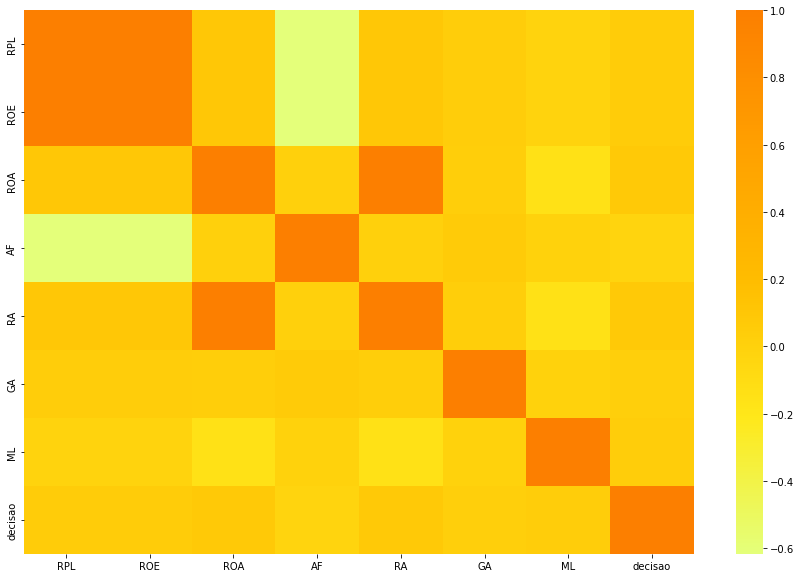

In [87]:
print_correlacoes(df)

               ROE          ROA           GA           ML      decisao
count  1674.000000  1674.000000  1674.000000  1674.000000  1674.000000
mean      0.036077     0.009039     0.157492     0.059437     0.501195
std       0.546275     0.035960     0.135789    27.218248     0.500148
min      -4.408585    -0.965050    -0.179092  -640.913127     0.000000
25%       0.007132     0.001964     0.080802     0.011380     0.000000
50%       0.026461     0.009632     0.123475     0.076160     1.000000
75%       0.050185     0.019091     0.197190     0.183151     1.000000
max      19.719121     0.264753     1.011998   858.940772     1.000000
              ROE       ROA        GA        ML   decisao
ROE      1.000000  0.097146  0.045692 -0.010598  0.056338
ROA      0.097146  1.000000  0.030065 -0.143919  0.082430
GA       0.045692  0.030065  1.000000 -0.000087  0.023235
ML      -0.010598 -0.143919 -0.000087  1.000000  0.041171
decisao  0.056338  0.082430  0.023235  0.041171  1.000000


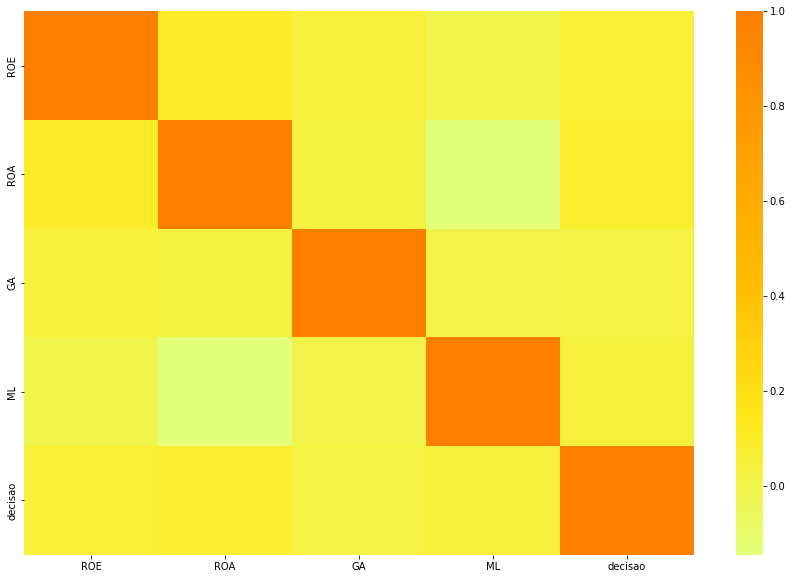

In [88]:
remover = ["RPL", "RA", "AF"]
df = df.drop(remover, axis=1)

print_correlacoes(df)

In [89]:
print(df.shape)

(1674, 5)


## Feature selection

In [90]:
! pip install sklearn

In [91]:
from sklearn.ensemble import ExtraTreesClassifier

modelo = ExtraTreesClassifier(random_state=1)
x = df.drop("decisao", axis=1)
y = df["decisao"]
modelo.fit(x, y)

caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
print(caracteristicas_importantes)
top10 = list(caracteristicas_importantes.index)[:10]
print(top10)

            0
GA   0.261690
ROE  0.250485
ROA  0.248610
ML   0.239215
['GA', 'ROE', 'ROA', 'ML']


In [92]:
from sklearn.preprocessing import StandardScaler

def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    return tabela_auxiliar

# nova_base_dados = ajustar_scaler(df)
nova_base_dados = df
# top10.append("decisao") 

# nova_base_dados = nova_base_dados[top10].reset_index(drop=True)
print(df)
print(nova_base_dados)

           ROE       ROA        GA        ML  decisao
0    -0.105253 -0.016222  0.172112 -0.094254        0
1    -0.104673 -0.018332  0.275444 -0.066555        0
2    -0.027526 -0.004677  0.164357 -0.028459        1
3    -0.032876 -0.005308  0.263596 -0.020139        1
4    -0.018787 -0.002987  0.277509 -0.010765        1
...        ...       ...       ...       ...      ...
1669  0.030807  0.009171  0.132155  0.069398        1
1670  0.031875  0.009289  0.140275  0.066217        1
1671  0.024589  0.008690  0.114133  0.076137        0
1672  0.020095  0.007375  0.114956  0.064159        1
1673 -0.003682 -0.001283  0.081393 -0.015768        1

[1674 rows x 5 columns]
           ROE       ROA        GA        ML  decisao
0    -0.105253 -0.016222  0.172112 -0.094254        0
1    -0.104673 -0.018332  0.275444 -0.066555        0
2    -0.027526 -0.004677  0.164357 -0.028459        1
3    -0.032876 -0.005308  0.263596 -0.020139        1
4    -0.018787 -0.002987  0.277509 -0.010765        1
...

In [93]:
from sklearn.model_selection import train_test_split

print(df.columns)
x = nova_base_dados.drop("decisao", axis=1)
y = nova_base_dados["decisao"]

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=1)

print(f"{x_treino=} {x_teste=} {y_treino=} {y_teste=}")

Index(['ROE', 'ROA', 'GA', 'ML', 'decisao'], dtype='object')
x_treino=           ROE       ROA        GA        ML
421   0.036637  0.014174  0.087354  0.162255
1169  0.033368  0.005714  0.353007  0.016186
1548  0.042175  0.014304  0.155255  0.092134
1557 -0.003608 -0.001134  0.120267 -0.009426
1071  0.094767  0.063527  0.155848  0.407624
...        ...       ...       ...       ...
715   0.084053 -0.002597  0.308203 -0.008425
905  -0.115514 -0.018215  0.083679 -0.217672
1096  0.039042  0.002995  0.224874  0.013321
235   0.029884  0.012153  0.097743  0.124339
1061  0.125044  0.018501  0.113321  0.163258

[1255 rows x 4 columns] x_teste=           ROE       ROA        GA        ML
979   0.045636  0.025330  0.213826  0.118463
1336  0.040667  0.016813  0.947242  0.017750
881   0.015356  0.003717  0.199353  0.018644
258   0.005831  0.002714  0.074314  0.036527
140   0.062898  0.029375  0.040879  0.718593
...        ...       ...       ...       ...
154   0.109457  0.028094  0.351265  0.0799

In [94]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

dummy = DummyClassifier(strategy="stratified", random_state=2)
dummy.fit(x_treino, y_treino)
previsao_dummy = dummy.predict(x_teste)

Dummy
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       210
           1       0.50      0.54      0.52       209

    accuracy                           0.50       419
   macro avg       0.50      0.50      0.50       419
weighted avg       0.50      0.50      0.50       419



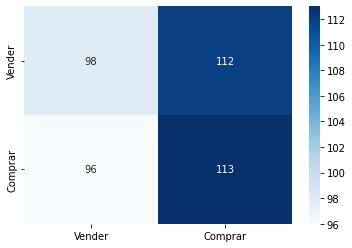

##################################################


In [95]:
def avaliar(y_teste, previsoes, nome_modelo):
    print(nome_modelo)
    report = classification_report(y_teste, previsoes)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, previsoes), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("#" * 50)
    
    
avaliar(y_teste, previsao_dummy, "Dummy")

## Modelos a serem testados

- AdaBoost
- Decision Tree
- Random Forest
- ExtraTree
- Gradient Boost
- K Nearest Neighbors (KNN)
- Logistic Regression
- Naive Bayes
- Support Vector Machine (SVM)
- Rede Neural

In [96]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

modelos = {
    "AdaBoost": AdaBoostClassifier(random_state=1),
    "DecisionTree": DecisionTreeClassifier(random_state=1),
    "RandomForest": RandomForestClassifier(random_state=1),
    "ExtraTree": ExtraTreesClassifier(random_state=1),
    "GradientBoost": GradientBoostingClassifier(random_state=1),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(random_state=1),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(random_state=1),
    "RedeNeural": MLPClassifier(random_state=1, max_iter=400),
}

AdaBoost
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       210
           1       0.51      0.50      0.51       209

    accuracy                           0.51       419
   macro avg       0.51      0.51      0.51       419
weighted avg       0.51      0.51      0.51       419



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but AdaBoostClassifier was fitted with feature names



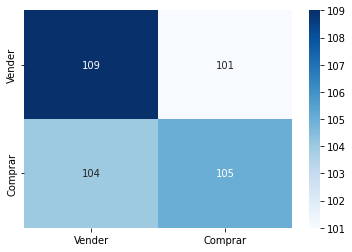

##################################################
DecisionTree
              precision    recall  f1-score   support

           0       0.54      0.59      0.56       210
           1       0.54      0.49      0.52       209

    accuracy                           0.54       419
   macro avg       0.54      0.54      0.54       419
weighted avg       0.54      0.54      0.54       419



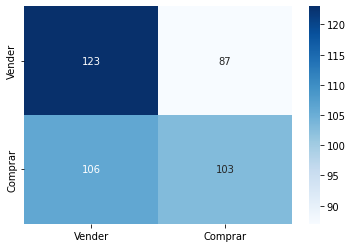

##################################################
RandomForest
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       210
           1       0.52      0.49      0.50       209

    accuracy                           0.52       419
   macro avg       0.52      0.52      0.52       419
weighted avg       0.52      0.52      0.52       419



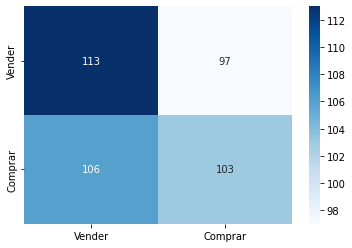

##################################################
ExtraTree
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       210
           1       0.50      0.50      0.50       209

    accuracy                           0.50       419
   macro avg       0.50      0.50      0.50       419
weighted avg       0.50      0.50      0.50       419



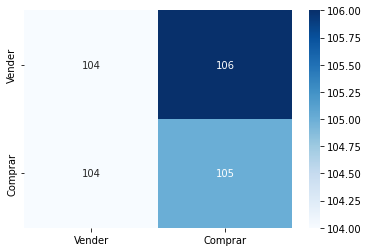

##################################################
GradientBoost
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       210
           1       0.53      0.52      0.53       209

    accuracy                           0.53       419
   macro avg       0.53      0.53      0.53       419
weighted avg       0.53      0.53      0.53       419



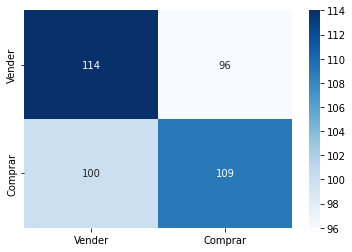

##################################################
KNN
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       210
           1       0.51      0.46      0.48       209

    accuracy                           0.51       419
   macro avg       0.51      0.51      0.50       419
weighted avg       0.51      0.51      0.50       419



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



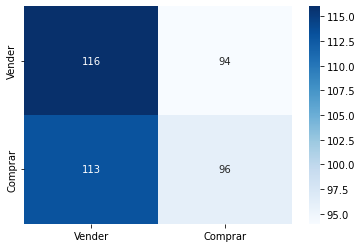

##################################################
LogisticRegression
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       210
           1       0.57      0.59      0.58       209

    accuracy                           0.57       419
   macro avg       0.57      0.57      0.57       419
weighted avg       0.57      0.57      0.57       419



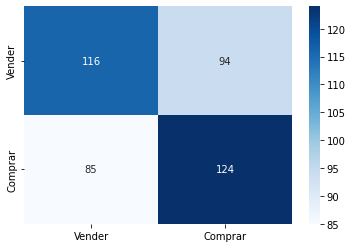

##################################################
NaiveBayes
              precision    recall  f1-score   support

           0       0.50      0.97      0.66       210
           1       0.42      0.02      0.05       209

    accuracy                           0.50       419
   macro avg       0.46      0.50      0.35       419
weighted avg       0.46      0.50      0.35       419



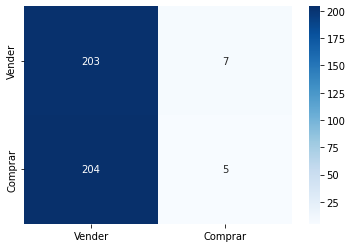

##################################################
SVM
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       210
           1       0.50      1.00      0.67       209

    accuracy                           0.50       419
   macro avg       0.75      0.50      0.34       419
weighted avg       0.75      0.50      0.34       419



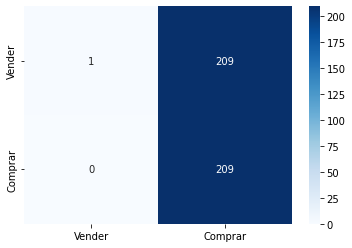

##################################################
RedeNeural
              precision    recall  f1-score   support

           0       0.57      0.54      0.55       210
           1       0.56      0.59      0.57       209

    accuracy                           0.56       419
   macro avg       0.56      0.56      0.56       419
weighted avg       0.56      0.56      0.56       419



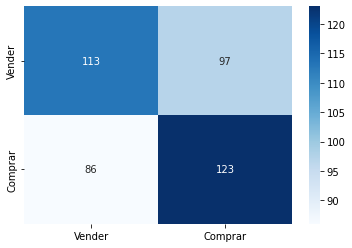

##################################################


In [97]:
for nome_modelo in modelos:
    modelo = modelos[nome_modelo]
    modelo.fit(x_treino, y_treino)
    previsoes = modelo.predict(x_teste)
    avaliar(y_teste, previsoes, nome_modelo)
    modelos[nome_modelo] = modelo